# Classifier Training
This file contains the process for training and testing a Random Forest Classifier on the converted image data.
An Orthogonalisation strategy is initially carried out to see what problems there might be fitting the Random Forest. Then 3-fold cross validation is carried out to optmise properly. Finally, the performance is compared to a simple K-means algorithm.

In [1]:
# Import packages
from sklearn.datasets import fetch_lfw_people
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import PIL
from resizeimage import resizeimage
import os
from pydataset import data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Set random seed
seed = 42
np.random.seed(seed)

In [2]:
# Load converted Data set
X = pickle.load(open("converted_data/X.p", "rb"))
y = pickle.load(open("converted_data/y.p", "rb"))

In [3]:
# Split data into test and train sets
# This method also shuffles the data, which is nice.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Initial Training to get a sense of the parameter ranges needed.
The idea here is to vary parameters one at a time to get a sense of where the biggest improvements are going to come from. Ideally, the search space when it comes to proper cross validation is as low as possible. This will simply give use more of an idea about where the best parameters are going to be, in a nice orthogonalised way.

### Varying the number of Estimators

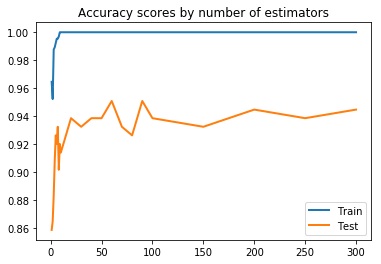

In [4]:
# To illustrate the train/test trade off. Here is a graph of the performance of the Random Forest
# of accuracy per n_estiamtors for both the training and test set for optimising for the gini
# coefficient.

estimators_counts = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,150,200,250,300]
train_array = []
test_array = []
for n_estimators in estimators_counts:
    rf = RandomForestClassifier(n_estimators=n_estimators)
    rf.fit(X_train, y_train)
    train_array.append(rf.score(X_train, y_train))
    test_array.append(rf.score(X_test, y_test))

line_train, = plt.plot(estimators_counts, train_array, linewidth=2.0, label='Train')
line_test, = plt.plot(estimators_counts, test_array, linewidth=2.0, label='Test')
plt.legend([line_train, line_test], ['Train', 'Test'])

plt.title('Accuracy scores by number of estimators')
plt.show()

The classifier very quickly rote learns the train set but leaves an approximate 5% gap between train/test performance.
This suggests a variance problem. Clearly, bias is not a problem, but we are fitting the training set 100% and not doing so well on the test set.

### Varying the minimum number of samples at each leaf.

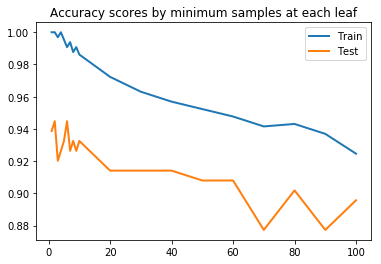

In [5]:
# To illustrate the train/test trade off with the minimum leaf count. Here is a graph of the performance of the Random Forest
# of accuracy per leaf count for both the training and test set for optimising for the gini
# coefficient, and 60 estimators

min_leaf_counts = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
train_array = []
test_array = []
for min_leaf_count in min_leaf_counts:
    rf = RandomForestClassifier(n_estimators=60, min_samples_leaf=min_leaf_count)
    rf.fit(X_train, y_train)
    train_array.append(rf.score(X_train, y_train))
    test_array.append(rf.score(X_test, y_test))
    
line_train, = plt.plot(min_leaf_counts, train_array, linewidth=2.0, label='Train')
line_test, = plt.plot(min_leaf_counts, test_array, linewidth=2.0, label='Test')
plt.legend([line_train, line_test], ['Train', 'Test'])

plt.title('Accuracy scores by minimum samples at each leaf')
plt.show()

As you can see, very low numbers for the minimum leaf count are important otherwise bias starts kicking in very quickly.

### Varying the max number of features per tree.
There are 30,000 features (100x100x3) per image. Normally a standard amount for a random forest is sqrt(no_features) which would be 173 in our case.

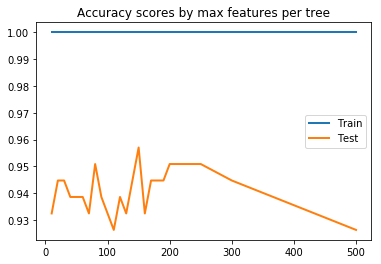

In [6]:
# To illustrate the train/test trade off with max number of features. Here is a graph of the performance of the Random Forest
# of accuracy per n_estiamtors for both the training and test set for optimising for the gini
# coefficient, 60 estimators, and 70 min leaf count

feature_counts = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,250,300,500]
train_array = []
test_array = []
for feature_count in feature_counts:
    rf = RandomForestClassifier(n_estimators=60, min_samples_leaf=1, max_features=feature_count)
    rf.fit(X_train, y_train)
    train_array.append(rf.score(X_train, y_train))
    test_array.append(rf.score(X_test, y_test))
    
line_train, = plt.plot(feature_counts, train_array, linewidth=2.0, label='Train')
line_test, = plt.plot(feature_counts, test_array, linewidth=2.0, label='Test')
plt.legend([line_train, line_test], ['Train', 'Test'])

plt.title('Accuracy scores by max features per tree')
plt.show()

The best performance is around the 140 mark, with overfitting beginning to kick in at the higher numbers.

### Varying the minimum impurity at each leaf
In the last parameter to vary, the minimum impurity at each leaf shall be changed.

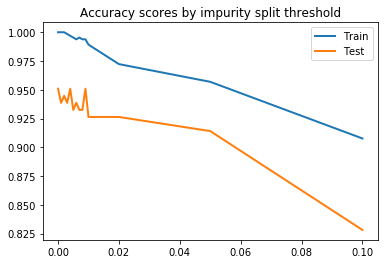

In [10]:
impurities = [0,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.05,0.1]
train_array = []
test_array = []
for impurity in impurities:
    rf = RandomForestClassifier(n_estimators=60, min_samples_leaf=1, max_features=140, min_impurity_decrease=impurity)
    rf.fit(X_train, y_train)
    train_array.append(rf.score(X_train, y_train))
    test_array.append(rf.score(X_test, y_test))
    
line_train, = plt.plot(impurities, train_array, linewidth=2.0, label='Train')
line_test, = plt.plot(impurities, test_array, linewidth=2.0, label='Test')
plt.legend([line_train, line_test], ['Train', 'Test'])

plt.title('Accuracy scores by impurity split threshold')
plt.show()

The graph here shows the algorithm very decidedly sticking to low impurities.

## 3-Fold Cross-Validation
Using the ball-park figures from the orthogonalised varying above, perform 3-fold-cross-validation, using those results as guidelines.

In [11]:
# Fit a Random Forest Classifier with 3 fold cross validation
estimators_counts = [60,80,100,120,140,160,180,200]
max_features = [80,100,120,140,160,180,200,220]
rf = RandomForestClassifier()
parameters = {
    'n_estimators': estimators_counts,
    'min_impurity_decrease': [0],
    'min_samples_leaf': [1],
    'max_features': max_features
}
rf_clf = GridSearchCV(rf, parameters, cv=3, scoring='accuracy', return_train_score=True)
rf_clf.fit(X_train, y_train)


# Apply Cross validated best clasifier to Test Set
y_true, y_pred = y_test, rf_clf.predict(X_test)

# Analyse Test results
confusion = np.array(confusion_matrix(y_true, y_pred))
print(confusion)
print(classification_report(y_true, y_pred))
print()
print('Test Accuracy: ', rf_clf.score(X_test, y_test))

# Classification Accuracies per class
for i in range(2):
    correct = confusion[i,i]
    total = np.sum(confusion[i,:])
    acc = correct/total
    if i == 1:
        name = 'Face'
    else:
        name = 'Place'

    print(name, 'accuracy: ', acc)

print(rf_clf.best_params_)

[[64  6]
 [ 3 90]]
             precision    recall  f1-score   support

        0.0       0.96      0.91      0.93        70
        1.0       0.94      0.97      0.95        93

avg / total       0.95      0.94      0.94       163


Test Accuracy:  0.944785276074
Place accuracy:  0.914285714286
Face accuracy:  0.967741935484
{'max_features': 200, 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'n_estimators': 60}


In [12]:
# Compare to a KNN with 3 fold cross validation on number of neighbours
knn = KNeighborsClassifier()
parameters = { 'n_neighbors': [3,4,5,6,7] }
knn_clf = GridSearchCV(knn, parameters, scoring='accuracy', return_train_score=True)
knn_clf.fit(X_train, y_train)

# Apply Cross validated best clasifier to Test Set
y_true, y_pred = y_test, knn_clf.predict(X_test)

# Analyse Test results
confusion = np.array(confusion_matrix(y_true, y_pred))
print(confusion)
print(classification_report(y_true, y_pred))
print()
print(knn_clf.best_params_)
print()

# Classification Accuracies per class
for i in range(2):
    correct = confusion[i,i]
    total = np.sum(confusion[i,:])
    acc = correct/total
    if i == 1:
        name = 'face'
    else:
        name = 'place'

    print("%s : %0.3f" % (name, acc))

[[66  4]
 [15 78]]
             precision    recall  f1-score   support

        0.0       0.81      0.94      0.87        70
        1.0       0.95      0.84      0.89        93

avg / total       0.89      0.88      0.88       163


{'n_neighbors': 5}

place : 0.943
face : 0.839


In [13]:
# Compare best accuracy scores
print('Random Forest Accuracy: ', rf_clf.score(X_test, y_test))
print('KNN Accuracy: ', knn_clf.score(X_test, y_test))

Random Forest Accuracy:  0.944785276074
KNN Accuracy:  0.883435582822


Although, the Random Forest outperforms the KNN in accuracy, it still perfectly learns the training set. There is a approximately 4% performance gap between the train and test accuracies, suggesting a variance issue. However, 96% obviously not dreadful given the time scope of this project. Given more time, I would have collected more data as well as looking for more parameter variations in the hope of reducing the variance. Perhaps other algorithms such as Convolutional Neural Networks's with decent regularistion, in the form of dropout or simple L2 regularisation in the cost function, would help get better test performance. However, this is beyond the scope of this project.

In [14]:
# Save trained Random Forest Classifier to server
pickle.dump(rf_clf, open("../server/classifiers/classfier.p", "wb"))

In [15]:
# Test performance on Onfido Images
onfido_faces = pickle.load(open("converted_data/onfido_faces.p", "rb"))
onfido_places = pickle.load(open("converted_data/onfido_places.p", "rb"))

accuracy_on_onfido_faces = np.mean(rf_clf.predict(onfido_faces))
accuracy_on_onfido_places = 1 - np.mean(rf_clf.predict(onfido_places))

print('Onfido Face Prediction: ', accuracy_on_onfido_faces)
print('Onfido Place Prediction: ', accuracy_on_onfido_places)

Onfido Face Prediction:  0.769230769231
Onfido Place Prediction:  0.933333333333


Given that the tech test specification said that the 'private' data for which I will be briefly evaluated is similar to the images that Onfido gave me with the test, the above is a a mixed-feeling result. It perhaps shows that I should have got images from other sources, as, particularly the faces dont seem to be generalising incredibly. Admittedly, there are very few examples in the images I received.